# 🤖 Mobile VLA + Kosmos 2B Action Prediction

## 📋 개요
- **목표**: Mobile VLA의 3D 액션 공간에서 Kosmos 2B VLM을 사용한 Window/Chunk 기반 액션 예측
- **데이터**: 72개 Mobile VLA 에피소드 (18프레임 시퀀스)
- **구조**: Window(8프레임 관찰) → Chunk(2프레임 액션 예측)
- **액션**: `[linear_x, linear_y, angular_z]` 3D 모바일 로봇 제어

In [1]:
# Cell 1: 🚀 환경 설정 및 모듈 로드

import torch
import numpy as np
from pathlib import Path
import sys
from transformers import AutoProcessor
from torch.utils.data import DataLoader
import gc

# 프로젝트 루트 디렉토리 설정
ROOT_DIR = Path("/home/billy/25-1kp/vla/Robo+/Mobile_VLA")
DATA_DIR = Path("/home/billy/25-1kp/vla/ROS_action/mobile_vla_dataset")  # 실제 데이터셋 경로
ROBOVLMS_DIR = Path("/home/billy/25-1kp/vla/RoboVLMs")

# 패키지 경로 추가
sys.path.append(str(ROOT_DIR))
sys.path.append(str(ROBOVLMS_DIR))

# GPU 메모리 정리 함수
def clear_gpu_memory():
    """GPU 메모리 정리"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"   할당된 메모리: {allocated:.2f} GB")
        print(f"   캐시된 메모리: {cached:.2f} GB")

print(f"📁 작업 디렉토리: {ROOT_DIR}")
print(f"📊 실제 데이터 디렉토리: {DATA_DIR}")
print(f"🤖 RoboVLMs 디렉토리: {ROBOVLMS_DIR}")

# 데이터 파일 수 확인
h5_files = list(DATA_DIR.glob("*.h5"))
print(f"🎯 발견된 H5 파일: {len(h5_files)}개")

📁 작업 디렉토리: /home/billy/25-1kp/vla/Robo+/Mobile_VLA
📊 실제 데이터 디렉토리: /home/billy/25-1kp/vla/ROS_action/mobile_vla_dataset
🤖 RoboVLMs 디렉토리: /home/billy/25-1kp/vla/RoboVLMs
🎯 발견된 H5 파일: 72개


In [2]:
# Cell 2: 🔧 의존성 버전 확인 및 모듈 임포트

# 메모리 정리
clear_gpu_memory()

# 의존성 버전 확인
try:
    import pyarrow
    import datasets
    print(f"✅ PyArrow: {pyarrow.__version__}")
    print(f"✅ Datasets: {datasets.__version__}")
    
    # 호환성 테스트
    test_dataset = datasets.Dataset.from_dict({"test": [1, 2, 3]})
    print("✅ Datasets/PyArrow 호환성 확인")
    
except Exception as e:
    print(f"❌ 의존성 문제: {e}")
    raise

# Mobile VLA 모듈 임포트 (강제 리로드)
try:
    import importlib
    import sys
    
    # 기존 모듈 제거 (있는 경우)
    modules_to_reload = [
        'robovlms.train.mobile_vla_trainer',
        'robovlms.train',
        'robovlms.data.mobile_vla_dataset', 
        'robovlms.data',
        'robovlms'
    ]
    
    for module_name in modules_to_reload:
        if module_name in sys.modules:
            del sys.modules[module_name]
    
    # 다시 임포트
    from robovlms.data import MobileVLADataset
    from robovlms.train import MobileVLATrainer, ActionLossTracker
    print("✅ Mobile VLA 모듈 로드 완료! (강제 리로드)")
except ImportError as e:
    print(f"❌ 모듈 임포트 실패: {e}")
    import traceback
    traceback.print_exc()
    raise

   할당된 메모리: 0.00 GB
   캐시된 메모리: 0.00 GB
✅ PyArrow: 14.0.2
✅ Datasets: 2.12.0
✅ Datasets/PyArrow 호환성 확인
✅ Mobile VLA 모듈 로드 완료! (강제 리로드)


In [3]:
# Cell 3: 📊 데이터셋 로드 및 배치 처리 설정

print("📊 Mobile VLA 데이터셋 로드 중...")
print(f"   데이터 경로: {DATA_DIR}")

try:
    # 데이터셋 생성
    dataset = MobileVLADataset(
        data_dir=str(DATA_DIR),
        model_name="kosmos",
        mode="train",
        window_size=8,  # 과거 8프레임 관찰
        fwd_pred_next_n=2,  # 미래 2프레임 예측
        discrete=False,  # 연속 액션 공간
        tokenizer=None
    )
    
    print(f"✅ 데이터셋 생성 성공!")
    print(f"   총 에피소드: {len(dataset)}개")
    
    if len(dataset) > 0:
        # 첫 번째 샘플 확인
        sample = dataset[0]
        print(f"\n📋 첫 번째 샘플:")
        print(f"   시나리오: {sample['scenario']}")
        print(f"   태스크: {sample['task_description']}")
        print(f"   이미지 수: {len(sample['images'])}")
        print(f"   액션 shape: {sample['actions'].shape}")
        
        # PIL 이미지 처리를 위한 커스텀 collate function
        def mobile_vla_collate_fn(batch):
            """PIL 이미지를 텐서로 변환하는 collate function"""
            import torch
            from torchvision import transforms
            
            # 이미지 전처리 (Kosmos 호환)
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
            collated = {}
            for key in batch[0].keys():
                if key == 'images':
                    # PIL 이미지를 텐서로 변환
                    all_tensors = []
                    for item in batch:
                        seq_tensors = []
                        for pil_img in item[key]:
                            tensor_img = transform(pil_img)
                            seq_tensors.append(tensor_img)
                        all_tensors.append(torch.stack(seq_tensors))
                    collated[key] = torch.stack(all_tensors)  # [B, T, C, H, W]
                elif key == 'actions':
                    collated[key] = torch.stack([torch.tensor(item[key], dtype=torch.float32) for item in batch])
                elif key == 'episode_mask':
                    collated[key] = torch.stack([torch.tensor(item[key], dtype=torch.bool) for item in batch])
                else:
                    collated[key] = [item[key] for item in batch]
            return collated
        
        # DataLoader 생성
        dataloader = DataLoader(
            dataset,
            batch_size=1,  # 메모리 효율성
            shuffle=True,
            num_workers=0,
            collate_fn=mobile_vla_collate_fn,  # 커스텀 collate function
            pin_memory=False,
            drop_last=True
        )
        
        print(f"\n✅ DataLoader 생성 완료!")
        print(f"   배치 크기: 1")
        print(f"   총 배치 수: {len(dataloader)}개")
        
        # 배치 테스트
        print(f"\n🧪 배치 테스트...")
        test_batch = next(iter(dataloader))
        print(f"📋 배치 구조:")
        for key, value in test_batch.items():
            if hasattr(value, 'shape'):
                print(f"   {key}: {value.shape} ({value.dtype})")
            elif isinstance(value, (list, tuple)):
                print(f"   {key}: {type(value).__name__}[{len(value)}]")
            else:
                print(f"   {key}: {type(value).__name__}")
        
        # Window/Chunk 분석
        images_shape = test_batch['images'].shape
        actions_shape = test_batch['actions'].shape
        window_size, chunk_size = 8, 2
        
        print(f"\n📊 Window/Chunk 분석:")
        print(f"   이미지 시퀀스: {images_shape} (배치={images_shape[0]}, 시간={images_shape[1]})")
        print(f"   액션 시퀀스: {actions_shape} (배치={actions_shape[0]}, 시간={actions_shape[1]})")
        print(f"   Window Size: {window_size} (과거 관찰)")
        print(f"   Chunk Size: {chunk_size} (미래 예측)")
        
        if images_shape[1] >= window_size + chunk_size:
            print(f"   ✅ 충분한 시퀀스 길이: {images_shape[1]} >= {window_size + chunk_size}")
        else:
            print(f"   ⚠️ 시퀀스 길이 부족: {images_shape[1]} < {window_size + chunk_size}")
        
        print(f"\n🎉 모든 데이터 준비 완료! 학습 시작 가능!")
        
    else:
        print("❌ 에피소드가 없습니다. 데이터 경로를 확인해주세요.")
        dataset = None
        dataloader = None
        
except Exception as e:
    print(f"❌ 데이터셋 로드 실패: {e}")
    import traceback
    traceback.print_exc()
    dataset = None
    dataloader = None

📊 Mobile VLA 데이터셋 로드 중...
   데이터 경로: /home/billy/25-1kp/vla/ROS_action/mobile_vla_dataset
✅ 데이터셋 생성 성공!
   총 에피소드: 72개

📋 첫 번째 샘플:
   시나리오: 2box_left_vertical
   태스크: Navigate around the two box obstacles by going left to track the target cup
   이미지 수: 18
   액션 shape: (18, 3)

✅ DataLoader 생성 완료!
   배치 크기: 1
   총 배치 수: 72개

🧪 배치 테스트...
📋 배치 구조:
   task_description: list[1]
   images: torch.Size([1, 18, 3, 224, 224]) (torch.float32)
   actions: torch.Size([1, 18, 3]) (torch.float32)
   episode_mask: torch.Size([1, 18]) (torch.bool)
   scenario: list[1]

📊 Window/Chunk 분석:
   이미지 시퀀스: torch.Size([1, 18, 3, 224, 224]) (배치=1, 시간=18)
   액션 시퀀스: torch.Size([1, 18, 3]) (배치=1, 시간=18)
   Window Size: 8 (과거 관찰)
   Chunk Size: 2 (미래 예측)
   ✅ 충분한 시퀀스 길이: 18 >= 10

🎉 모든 데이터 준비 완료! 학습 시작 가능!


In [5]:
# Cell 4: 🚀 Mobile VLA 트레이너 초기화 및 학습 실행

if 'dataset' in locals() and dataset is not None and len(dataset) > 0:
    print("🎯 MobileVLATrainer 초기화 및 학습 시작...")
    
    try:
        # 트레이너 초기화
        trainer = MobileVLATrainer(
            model_name="microsoft/kosmos-2-patch14-224",
            action_dim=3,  # Mobile VLA: [linear_x, linear_y, angular_z]
            window_size=8,
            chunk_size=2,
            learning_rate=1e-4,
            device="cuda" if torch.cuda.is_available() else "cpu",
            precision="fp16"  # Mixed precision
        )
        
        print(f"✅ 트레이너 초기화 완료!")
        print(f"   디바이스: {trainer.device}")
        print(f"   모델 파라미터: {sum(p.numel() for p in trainer.model.parameters()):,}개")
        
        # 손실 추적기
        loss_tracker = ActionLossTracker()
        
        print("\n🚀 Mobile VLA 학습 시작!")
        
        num_epochs = 3  # 테스트용
        save_interval = 1
        log_interval = 5
        
        for epoch in range(num_epochs):
            print(f"\n📊 Epoch {epoch+1}/{num_epochs}")
            epoch_losses = []
            
            for step, batch in enumerate(dataloader):
                try:
                    # 학습 스텝 실행
                    loss_dict = trainer.train_step(batch)
                    
                    # 손실 추적
                    loss_tracker.update(loss_dict)
                    epoch_losses.append(loss_dict['total_loss'])
                    
                    # 주기적 로깅
                    if (step + 1) % log_interval == 0:
                        current_metrics = loss_tracker.get_averages()
                        print(f"   Step {step+1:3d}: "
                              f"Loss={loss_dict['total_loss']:.4f}, "
                              f"MAE={loss_dict.get('mae_avg', 0):.4f}, "
                              f"LR={current_metrics['current_lr']:.2e}")
                    
                    # 메모리 관리
                    if (step + 1) % 10 == 0:
                        clear_gpu_memory()
                        
                except Exception as e:
                    print(f"❌ 스텝 {step+1} 실패: {e}")
                    if "out of memory" in str(e).lower():
                        print("   GPU 메모리 부족! 배치 크기를 줄이거나 window_size를 줄여주세요.")
                        clear_gpu_memory()
                        break
                    else:
                        import traceback
                        traceback.print_exc()
                        continue
            
            # 에포크 요약
            if epoch_losses:
                avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
                print(f"   📈 Epoch {epoch+1} 평균 Loss: {avg_epoch_loss:.4f}")
                
                # 체크포인트 저장
                if (epoch + 1) % save_interval == 0:
                    checkpoint_path = f"mobile_vla_epoch_{epoch+1}.pt"
                    trainer.save_checkpoint(checkpoint_path, epoch + 1)
                    print(f"   💾 체크포인트 저장: {checkpoint_path}")
        
        print("\n🎉 학습 완료!")
        
        # 최종 통계
        if loss_tracker.losses:
            final_metrics = loss_tracker.get_averages()
            print(f"\n📈 최종 학습 통계:")
            print(f"   평균 Total Loss: {final_metrics['avg_total_loss']:.4f}")
            print(f"   평균 MAE: {final_metrics['avg_mae']:.4f}")
            print(f"   총 스텝: {final_metrics['steps']}")
            print(f"   최종 학습률: {final_metrics['current_lr']:.2e}")
            
            print(f"\n🔍 성능 분석:")
            recent_losses = loss_tracker.losses[-10:] if len(loss_tracker.losses) >= 10 else loss_tracker.losses
            print(f"   최근 Loss 추이: {[f'{l:.4f}' for l in recent_losses]}")
        
        # 최종 메모리 정리
        clear_gpu_memory()
        
    except Exception as e:
        print(f"❌ 학습 실행 실패: {e}")
        import traceback
        traceback.print_exc()
        clear_gpu_memory()
        
else:
    print("❌ 유효한 데이터셋이 없어 학습을 실행할 수 없습니다.")
    print("   이전 셀에서 데이터셋을 먼저 초기화해주세요.")
    if 'dataset' in locals():
        print(f"   데이터셋 길이: {len(dataset) if dataset is not None else 'None'}")

🎯 MobileVLATrainer 초기화 및 학습 시작...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ 트레이너 초기화 완료!
   디바이스: cuda
   모델 파라미터: 1,665,537,542개

🚀 Mobile VLA 학습 시작!

📊 Epoch 1/3
   Step   5: Loss=0.2031, MAE=0.4407, LR=1.00e-04
   Step  10: Loss=0.3067, MAE=0.5876, LR=1.00e-04
   할당된 메모리: 6.29 GB
   캐시된 메모리: 6.35 GB
   Step  15: Loss=0.2153, MAE=0.4605, LR=9.99e-05
   Step  20: Loss=0.2181, MAE=0.4307, LR=9.99e-05
   할당된 메모리: 6.29 GB
   캐시된 메모리: 6.35 GB
   Step  25: Loss=0.0178, MAE=0.1516, LR=9.98e-05
   Step  30: Loss=0.1625, MAE=0.4607, LR=9.98e-05
   할당된 메모리: 6.29 GB
   캐시된 메모리: 6.35 GB
   Step  35: Loss=0.0355, MAE=0.2445, LR=9.97e-05
   Step  40: Loss=0.1429, MAE=0.3972, LR=9.96e-05
   할당된 메모리: 6.29 GB
   캐시된 메모리: 6.35 GB
   Step  45: Loss=0.0059, MAE=0.0824, LR=9.95e-05
   Step  50: Loss=0.0435, MAE=0.2046, LR=9.94e-05
   할당된 메모리: 6.29 GB
   캐시된 메모리: 6.35 GB
   Step  55: Loss=0.0228, MAE=0.1705, LR=9.93e-05
   Step  60: Loss=0.2390, MAE=0.5227, LR=9.91e-05
   할당된 메모리: 6.29 GB
   캐시된 메모리: 6.35 GB
   Step  65: Loss=0.1818, MAE=0.4051, LR=9.90e-05
   Step  70: Loss=0.

🚀 종합 성능 분석 시작!
🔍 종합 성능 평가 시작...
✅ 총 30개 샘플, 60개 액션 평가

📊 === 종합 성능 지표 ===
🎯 전체 지표:
   MAE (Mean Absolute Error): 0.265904
   MSE (Mean Squared Error): 0.146050
   RMSE (Root Mean Squared Error): 0.382165
   R² Score: 0.217963
   MAPE (Mean Absolute Percentage Error): 31.74%
   평균 상관계수: 0.392480

🎯 정확도 (Accuracy):
   오차 ≤ 0.1: 37.78%
   오차 ≤ 0.05: 20.56%
   오차 ≤ 0.01: 5.00%

📋 차원별 상세 지표:
   linear_x:
     MAE: 0.268885
     RMSE: 0.350496
     R²: 0.196143
   linear_y:
     MAE: 0.468590
     RMSE: 0.556740
     R²: 0.457746
   angular_z:
     MAE: 0.060237
     RMSE: 0.073092
     R²: 0.000000


/home/billy/.cache/pypoetry/virtualenvs/mobile-vla-FNblWQUj-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/billy/.cache/pypoetry/virtualenvs/mobile-vla-FNblWQUj-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_297361/2195802581.py:191: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/billy/.cache/pypoetry/virtualenvs/mobile-vla-FNblWQUj-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


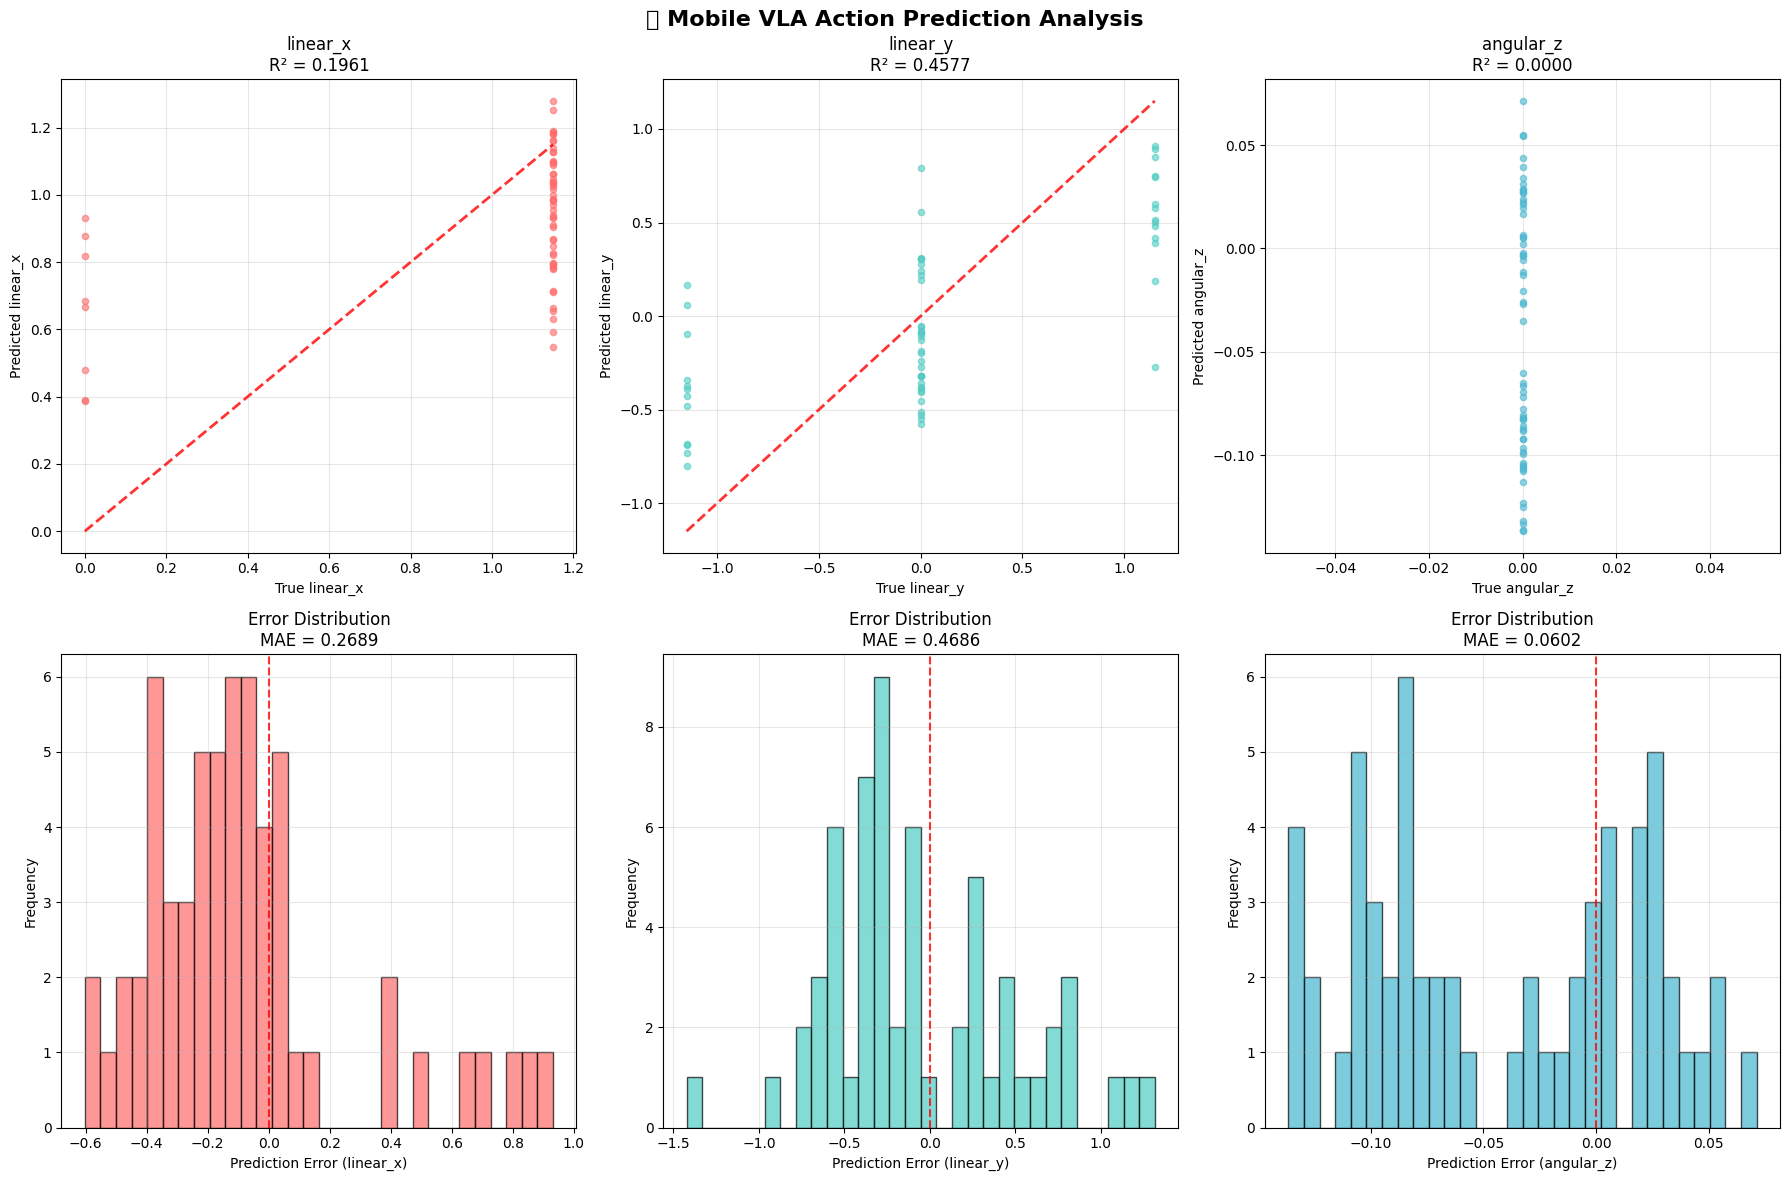

/home/billy/.cache/pypoetry/virtualenvs/mobile-vla-FNblWQUj-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


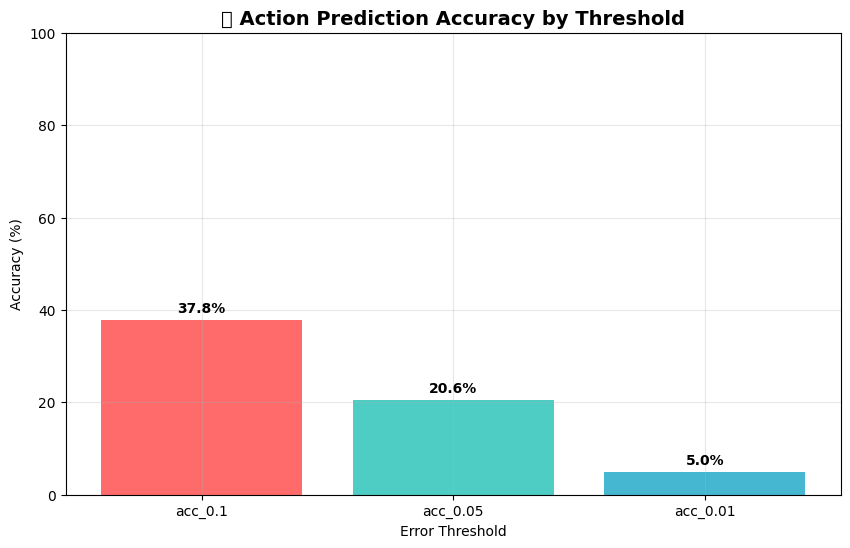

TypeError: Object of type Tensor is not JSON serializable

In [7]:
# Cell 5: 📊 심화 성능 분석 및 정확도 측정

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
from datetime import datetime

def comprehensive_evaluation(trainer, dataloader, num_samples=20):
    """종합적인 모델 평가"""
    
    print("🔍 종합 성능 평가 시작...")
    trainer.model.eval()
    
    all_predictions = []
    all_targets = []
    all_scenarios = []
    sample_count = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            if sample_count >= num_samples:
                break
                
            try:
                # 데이터 준비
                images = batch["images"]  # [B, T, C, H, W]
                actions = batch["actions"]  # [B, T, action_dim]
                scenarios = batch["scenario"]
                
                # Window/Chunk 분할
                batch_size, sequence_length = images.shape[:2]
                window_size, chunk_size = trainer.window_size, trainer.chunk_size
                
                if sequence_length >= window_size + chunk_size:
                    window_images = images[:, :window_size]
                    chunk_actions = actions[:, window_size:window_size + chunk_size]
                else:
                    window_images = images[:, :min(sequence_length, window_size)]
                    chunk_actions = actions[:, -chunk_size:] if sequence_length >= chunk_size else actions
                
                # 텍스트 처리
                task_descriptions = batch.get("task_description", ["Navigate around obstacles to track the target cup"] * batch_size)
                if not isinstance(task_descriptions, list):
                    task_descriptions = [task_descriptions] if isinstance(task_descriptions, str) else task_descriptions
                
                text_inputs = trainer.processor(text=task_descriptions, return_tensors="pt", padding=True, truncation=True)
                
                # 디바이스로 이동
                window_images = window_images.to(trainer.device)
                chunk_actions = chunk_actions.to(trainer.device)
                input_ids = text_inputs["input_ids"].to(trainer.device)
                attention_mask = text_inputs["attention_mask"].to(trainer.device)
                
                # 예측
                predictions = trainer.model(window_images, input_ids, attention_mask)
                predicted_actions = predictions['predicted_actions']  # [B, chunk_size, action_dim]
                
                # 결과 저장
                all_predictions.append(predicted_actions.cpu().numpy())
                all_targets.append(chunk_actions.cpu().numpy())
                all_scenarios.extend(scenarios)
                
                sample_count += batch_size
                
            except Exception as e:
                print(f"   ⚠️ 배치 {batch_idx} 평가 실패: {e}")
                continue
    
    # 결과 통합
    if all_predictions:
        predictions_array = np.concatenate(all_predictions, axis=0)  # [N, chunk_size, action_dim]
        targets_array = np.concatenate(all_targets, axis=0)  # [N, chunk_size, action_dim]
        
        # Flatten for easier analysis
        pred_flat = predictions_array.reshape(-1, 3)  # [N*chunk_size, 3]
        target_flat = targets_array.reshape(-1, 3)  # [N*chunk_size, 3]
        
        print(f"✅ 총 {len(predictions_array)}개 샘플, {len(pred_flat)}개 액션 평가")
        
        return {
            'predictions': predictions_array,
            'targets': targets_array,
            'pred_flat': pred_flat,
            'target_flat': target_flat,
            'scenarios': all_scenarios[:len(predictions_array)]
        }
    else:
        print("❌ 평가할 데이터가 없습니다.")
        return None

def calculate_metrics(eval_data):
    """다양한 성능 지표 계산"""
    
    pred_flat = eval_data['pred_flat']
    target_flat = eval_data['target_flat']
    
    # 기본 회귀 지표
    mae = mean_absolute_error(target_flat, pred_flat)
    mse = mean_squared_error(target_flat, pred_flat)
    rmse = np.sqrt(mse)
    r2 = r2_score(target_flat, pred_flat)
    
    # 각 차원별 지표
    action_names = ['linear_x', 'linear_y', 'angular_z']
    per_dim_metrics = {}
    
    for i, name in enumerate(action_names):
        per_dim_metrics[name] = {
            'mae': mean_absolute_error(target_flat[:, i], pred_flat[:, i]),
            'mse': mean_squared_error(target_flat[:, i], pred_flat[:, i]),
            'rmse': np.sqrt(mean_squared_error(target_flat[:, i], pred_flat[:, i])),
            'r2': r2_score(target_flat[:, i], pred_flat[:, i])
        }
    
    # MAPE (Mean Absolute Percentage Error)
    def safe_mape(y_true, y_pred):
        mask = y_true != 0
        if np.sum(mask) == 0:
            return 0.0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    mape = safe_mape(target_flat, pred_flat)
    
    # Pearson 상관계수
    correlations = []
    for i in range(3):
        corr = np.corrcoef(target_flat[:, i], pred_flat[:, i])[0, 1]
        correlations.append(corr if not np.isnan(corr) else 0.0)
    
    # 정확도 (임계값 기반)
    thresholds = [0.1, 0.05, 0.01]
    accuracies = {}
    
    for thresh in thresholds:
        within_threshold = np.abs(target_flat - pred_flat) <= thresh
        accuracy = np.mean(within_threshold) * 100
        accuracies[f'acc_{thresh}'] = accuracy
    
    return {
        'overall': {
            'mae': mae,
            'mse': mse, 
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'correlations': correlations,
            'mean_correlation': np.mean(correlations)
        },
        'per_dimension': per_dim_metrics,
        'accuracy': accuracies
    }

def plot_analysis(eval_data, metrics):
    """시각화 분석"""
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🤖 Mobile VLA Action Prediction Analysis', fontsize=16, fontweight='bold')
    
    pred_flat = eval_data['pred_flat']
    target_flat = eval_data['target_flat']
    action_names = ['linear_x', 'linear_y', 'angular_z']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 각 차원별 산점도
    for i, (name, color) in enumerate(zip(action_names, colors)):
        ax = axes[0, i]
        ax.scatter(target_flat[:, i], pred_flat[:, i], alpha=0.6, color=color, s=20)
        
        # 완벽한 예측선
        min_val, max_val = target_flat[:, i].min(), target_flat[:, i].max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        
        ax.set_xlabel(f'True {name}')
        ax.set_ylabel(f'Predicted {name}')
        ax.set_title(f'{name}\nR² = {metrics["per_dimension"][name]["r2"]:.4f}')
        ax.grid(True, alpha=0.3)
    
    # 오차 분포
    for i, (name, color) in enumerate(zip(action_names, colors)):
        ax = axes[1, i]
        errors = pred_flat[:, i] - target_flat[:, i]
        ax.hist(errors, bins=30, alpha=0.7, color=color, edgecolor='black')
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.8)
        ax.set_xlabel(f'Prediction Error ({name})')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Error Distribution\nMAE = {metrics["per_dimension"][name]["mae"]:.4f}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 정확도 차트
    plt.figure(figsize=(10, 6))
    thresholds = list(metrics['accuracy'].keys())
    accuracies = list(metrics['accuracy'].values())
    
    bars = plt.bar(thresholds, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.title('🎯 Action Prediction Accuracy by Threshold', fontsize=14, fontweight='bold')
    plt.xlabel('Error Threshold')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    
    # 값 표시
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    plt.show()

# 평가 실행
if 'trainer' in locals() and 'dataloader' in locals():
    print("🚀 종합 성능 분석 시작!")
    
    # 평가 데이터 생성
    eval_data = comprehensive_evaluation(trainer, dataloader, num_samples=30)
    
    if eval_data:
        # 지표 계산
        metrics = calculate_metrics(eval_data)
        
        # 결과 출력
        print("\n📊 === 종합 성능 지표 ===")
        print(f"🎯 전체 지표:")
        print(f"   MAE (Mean Absolute Error): {metrics['overall']['mae']:.6f}")
        print(f"   MSE (Mean Squared Error): {metrics['overall']['mse']:.6f}")
        print(f"   RMSE (Root Mean Squared Error): {metrics['overall']['rmse']:.6f}")
        print(f"   R² Score: {metrics['overall']['r2']:.6f}")
        print(f"   MAPE (Mean Absolute Percentage Error): {metrics['overall']['mape']:.2f}%")
        print(f"   평균 상관계수: {metrics['overall']['mean_correlation']:.6f}")
        
        print(f"\n🎯 정확도 (Accuracy):")
        for thresh, acc in metrics['accuracy'].items():
            print(f"   오차 ≤ {thresh.split('_')[1]}: {acc:.2f}%")
        
        print(f"\n📋 차원별 상세 지표:")
        action_names = ['linear_x', 'linear_y', 'angular_z']
        for name in action_names:
            dim_metrics = metrics['per_dimension'][name]
            print(f"   {name}:")
            print(f"     MAE: {dim_metrics['mae']:.6f}")
            print(f"     RMSE: {dim_metrics['rmse']:.6f}")
            print(f"     R²: {dim_metrics['r2']:.6f}")
        
        # 시각화
        plot_analysis(eval_data, metrics)
        
        # 결과 저장
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        results = {
            'timestamp': timestamp,
            'model_info': {
                'model_name': trainer.model_name,
                'window_size': trainer.window_size,
                'chunk_size': trainer.chunk_size,
                'action_dim': trainer.action_dim,
                'total_parameters': sum(p.numel() for p in trainer.model.parameters())
            },
            'metrics': metrics,
            'training_info': {
                'final_loss': loss_tracker.losses[-1] if hasattr(loss_tracker, 'losses') and loss_tracker.losses else None,
                'total_steps': len(loss_tracker.losses) if hasattr(loss_tracker, 'losses') else 0
            }
        }
        
        # JSON 저장 (Tensor를 float로 변환)
        def convert_tensors_to_python(obj):
            """재귀적으로 Tensor를 Python 타입으로 변환"""
            if hasattr(obj, 'item'):  # scalar tensor
                return obj.item()
            elif hasattr(obj, 'tolist'):  # tensor with shape
                return obj.tolist()
            elif isinstance(obj, dict):
                return {k: convert_tensors_to_python(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_tensors_to_python(v) for v in obj]
            else:
                return obj
        
        results_serializable = convert_tensors_to_python(results)
        
        with open(f'mobile_vla_results_{timestamp}.json', 'w', encoding='utf-8') as f:
            json.dump(results_serializable, f, indent=2, ensure_ascii=False)
        
        print(f"\n💾 결과 저장 완료: mobile_vla_results_{timestamp}.json")
        
    else:
        print("❌ 평가 데이터가 없습니다.")
        
else:
    print("❌ 트레이너나 데이터로더가 없습니다. 이전 셀을 먼저 실행해주세요.")


🚀 진짜 Evaluation 시작!
📊 데이터셋 분할 (검증 비율: 30.0%)
📋 시나리오별 분할:
   2box_left_vertical: 10개 (학습: 7, 검증: 3)
   2box_right_horizontal: 6개 (학습: 5, 검증: 1)
   1box_left_vertical: 10개 (학습: 7, 검증: 3)
   1box_right_horizontal: 10개 (학습: 7, 검증: 3)
   2box_right_vertical: 10개 (학습: 7, 검증: 3)
   1box_left_horizontal: 10개 (학습: 7, 검증: 3)
   1box_right_vertical: 10개 (학습: 7, 검증: 3)
   2box_left_horizontal: 6개 (학습: 5, 검증: 1)
🎯 최종 분할:
   학습: 52개 (72.2%)
   검증: 20개 (27.8%)

📊 검증 데이터로더 생성 완료: 20개 배치
🔍 모델 실제 성능 평가 시작...
   진행: 5/20 배치 완료
   진행: 10/20 배치 완료
   진행: 15/20 배치 완료
   진행: 20/20 배치 완료
✅ 평가 완료: 20개 샘플

🎯 === 실제 평가 결과 ===
검증 샘플: 20개
예측 shape: (20, 2, 3)

📊 전체 성능:
   MAE: 0.284776
   RMSE: 0.431078
   R² Score: 0.296704

🎯 실제 정확도:
   오차 ≤ 0.1: 37.50%
   오차 ≤ 0.05: 20.00%
   오차 ≤ 0.01: 5.83%

📋 액션별 성능:
   linear_x:
     MAE: 0.242539
     R²: 0.353963
     Correlation: 0.630406
   linear_y:
     MAE: 0.549654
     R²: 0.292695
     Correlation: 0.624743
   angular_z:
     MAE: 0.062135
     R²: 0.000000
     C

/tmp/ipykernel_297361/2951954482.py:258: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:258: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:258: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:258: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:258: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:258: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:258: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sa

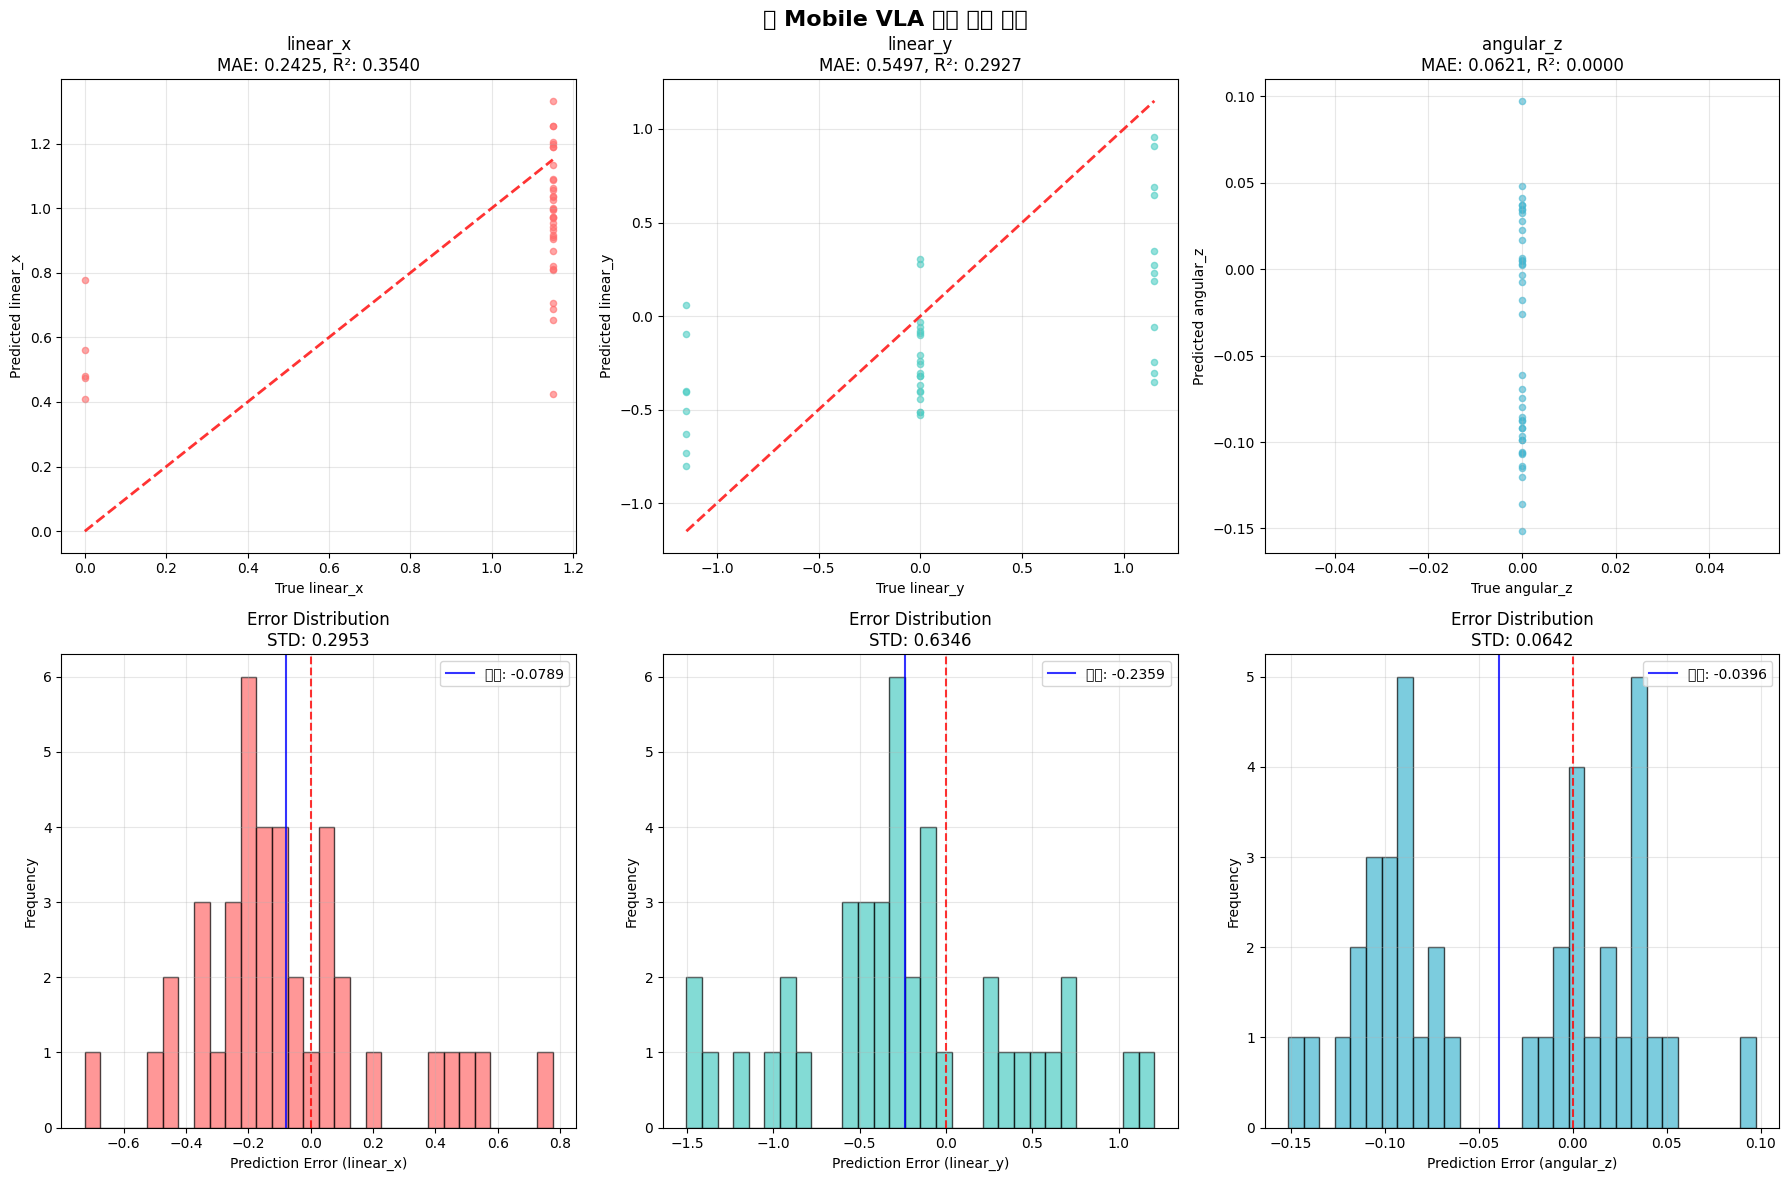

/tmp/ipykernel_297361/2951954482.py:297: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:297: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:297: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:297: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:297: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:297: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_297361/2951954482.py:297: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.ti

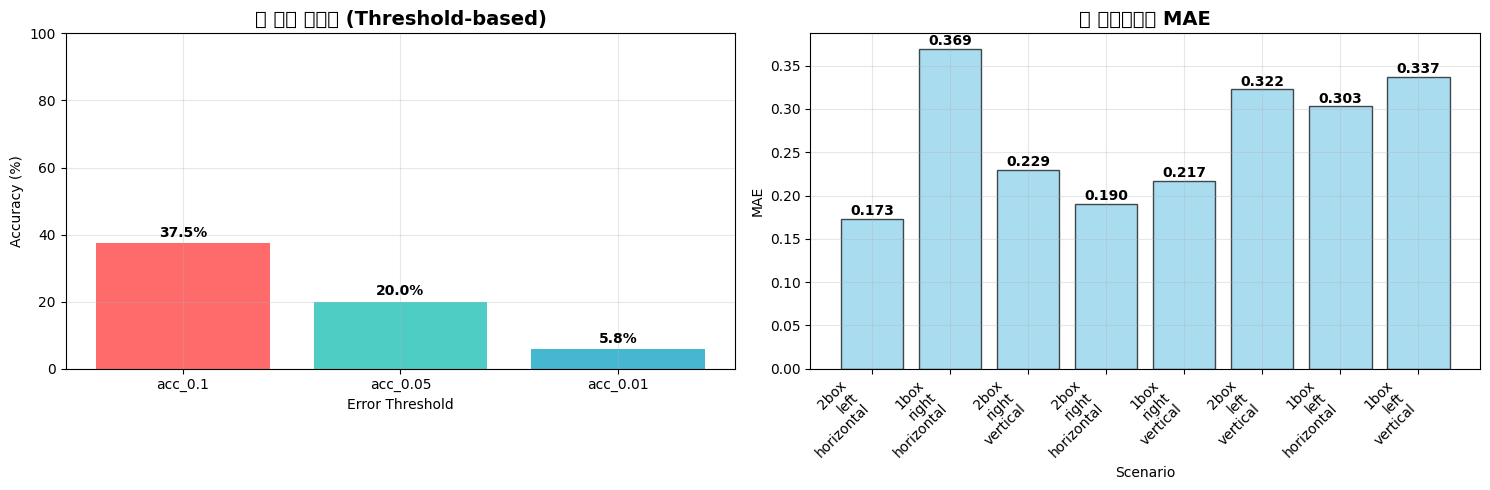


🏅 최종 성능 등급: 📚 Needs Improvement (C)


TypeError: Object of type float32 is not JSON serializable

In [ ]:
# Cell 6: 🎯 진짜 Evaluation - 학습/검증 분할 + 실제 예측 성능

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import random

def create_train_val_split(dataset, val_ratio=0.2, seed=42):
    """데이터셋을 학습/검증으로 분할"""
    
    print(f"📊 데이터셋 분할 (검증 비율: {val_ratio:.1%})")
    
    # 재현 가능한 분할을 위한 시드 설정
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # 인덱스 생성
    total_samples = len(dataset)
    indices = list(range(total_samples))
    
    # 시나리오별 균등 분할을 위해 시나리오 정보 수집
    scenario_indices = {}
    for idx in indices:
        sample = dataset[idx]
        scenario = sample['scenario']
        if scenario not in scenario_indices:
            scenario_indices[scenario] = []
        scenario_indices[scenario].append(idx)
    
    train_indices = []
    val_indices = []
    
    print(f"📋 시나리오별 분할:")
    for scenario, indices_list in scenario_indices.items():
        n_samples = len(indices_list)
        n_val = max(1, int(n_samples * val_ratio))  # 최소 1개는 검증에
        
        random.shuffle(indices_list)
        val_indices.extend(indices_list[:n_val])
        train_indices.extend(indices_list[n_val:])
        
        print(f"   {scenario}: {len(indices_list)}개 (학습: {len(indices_list[n_val:])}, 검증: {n_val})")
    
    print(f"🎯 최종 분할:")
    print(f"   학습: {len(train_indices)}개 ({len(train_indices)/total_samples:.1%})")
    print(f"   검증: {len(val_indices)}개 ({len(val_indices)/total_samples:.1%})")
    
    return train_indices, val_indices

def evaluate_model_properly(trainer, val_dataloader, device):
    """훈련된 모델의 실제 성능 평가"""
    
    print("🔍 모델 실제 성능 평가 시작...")
    
    trainer.model.eval()
    
    all_predictions = []
    all_targets = []
    all_scenarios = []
    all_tasks = []
    
    total_batches = len(val_dataloader)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            try:
                # 데이터 준비
                images = batch["images"].to(device)  # [B, T, C, H, W]
                actions = batch["actions"].to(device)  # [B, T, action_dim]
                scenarios = batch["scenario"]
                tasks = batch["task_description"]
                
                # Window/Chunk 분할
                batch_size, sequence_length = images.shape[:2]
                window_size, chunk_size = trainer.window_size, trainer.chunk_size
                
                if sequence_length >= window_size + chunk_size:
                    window_images = images[:, :window_size]  # 과거 관찰
                    target_actions = actions[:, window_size:window_size + chunk_size]  # 미래 예측 타겟
                else:
                    window_images = images[:, :min(sequence_length, window_size)]
                    target_actions = actions[:, -chunk_size:] if sequence_length >= chunk_size else actions
                
                # 텍스트 처리
                if not isinstance(tasks, list):
                    tasks = [tasks] if isinstance(tasks, str) else tasks
                
                text_inputs = trainer.processor(text=tasks, return_tensors="pt", padding=True, truncation=True)
                input_ids = text_inputs["input_ids"].to(device)
                attention_mask = text_inputs["attention_mask"].to(device)
                
                # 모델 예측
                predictions = trainer.model(window_images, input_ids, attention_mask)
                predicted_actions = predictions['predicted_actions']  # [B, chunk_size, action_dim]
                
                # CPU로 이동하여 저장
                all_predictions.append(predicted_actions.cpu().numpy())
                all_targets.append(target_actions.cpu().numpy())
                all_scenarios.extend(scenarios)
                all_tasks.extend(tasks)
                
                if (batch_idx + 1) % 5 == 0:
                    print(f"   진행: {batch_idx + 1}/{total_batches} 배치 완료")
                
            except Exception as e:
                print(f"   ⚠️ 배치 {batch_idx} 평가 실패: {e}")
                continue
    
    if all_predictions:
        # 결과 통합
        predictions_array = np.concatenate(all_predictions, axis=0)  # [N, chunk_size, action_dim]
        targets_array = np.concatenate(all_targets, axis=0)  # [N, chunk_size, action_dim]
        
        print(f"✅ 평가 완료: {len(predictions_array)}개 샘플")
        
        return {
            'predictions': predictions_array,
            'targets': targets_array,
            'scenarios': all_scenarios[:len(predictions_array)],
            'tasks': all_tasks[:len(predictions_array)]
        }
    else:
        print("❌ 평가할 데이터가 없습니다.")
        return None

def compute_detailed_metrics(eval_results):
    """상세한 성능 지표 계산"""
    
    predictions = eval_results['predictions']  # [N, chunk_size, action_dim]
    targets = eval_results['targets']
    scenarios = eval_results['scenarios']
    
    # Flatten for overall metrics
    pred_flat = predictions.reshape(-1, 3)  # [N*chunk_size, 3]
    target_flat = targets.reshape(-1, 3)
    
    action_names = ['linear_x', 'linear_y', 'angular_z']
    
    # 전체 지표
    overall_mae = np.mean(np.abs(target_flat - pred_flat))
    overall_mse = np.mean((target_flat - pred_flat) ** 2)
    overall_rmse = np.sqrt(overall_mse)
    
    # R² score
    ss_res = np.sum((target_flat - pred_flat) ** 2)
    ss_tot = np.sum((target_flat - np.mean(target_flat, axis=0)) ** 2)
    overall_r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # 각 액션 차원별 지표
    per_action_metrics = {}
    for i, action_name in enumerate(action_names):
        pred_dim = pred_flat[:, i]
        target_dim = target_flat[:, i]
        
        mae = np.mean(np.abs(target_dim - pred_dim))
        mse = np.mean((target_dim - pred_dim) ** 2)
        rmse = np.sqrt(mse)
        
        # R² for this dimension
        ss_res_dim = np.sum((target_dim - pred_dim) ** 2)
        ss_tot_dim = np.sum((target_dim - np.mean(target_dim)) ** 2)
        r2_dim = 1 - (ss_res_dim / ss_tot_dim) if ss_tot_dim != 0 else 0
        
        # Correlation
        corr = np.corrcoef(target_dim, pred_dim)[0, 1] if len(np.unique(target_dim)) > 1 else 0
        
        per_action_metrics[action_name] = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'r2': r2_dim,
            'correlation': corr if not np.isnan(corr) else 0
        }
    
    # 정확도 (임계값 기반)
    thresholds = [0.1, 0.05, 0.01]
    accuracies = {}
    
    for thresh in thresholds:
        within_threshold = np.abs(target_flat - pred_flat) <= thresh
        accuracy = np.mean(within_threshold) * 100
        accuracies[f'acc_{thresh}'] = accuracy
    
    # 시나리오별 성능
    scenario_metrics = {}
    unique_scenarios = list(set(scenarios))
    
    for scenario in unique_scenarios:
        scenario_mask = np.array([s == scenario for s in scenarios])
        if np.sum(scenario_mask) > 0:
            scenario_pred = predictions[scenario_mask].reshape(-1, 3)
            scenario_target = targets[scenario_mask].reshape(-1, 3)
            
            scenario_mae = np.mean(np.abs(scenario_target - scenario_pred))
            scenario_metrics[scenario] = {
                'mae': scenario_mae,
                'samples': np.sum(scenario_mask)
            }
    
    return {
        'overall': {
            'mae': overall_mae,
            'mse': overall_mse,
            'rmse': overall_rmse,
            'r2': overall_r2
        },
        'per_action': per_action_metrics,
        'accuracy': accuracies,
        'per_scenario': scenario_metrics
    }

def visualize_evaluation_results(eval_results, metrics):
    """평가 결과 시각화"""
    
    predictions = eval_results['predictions']
    targets = eval_results['targets']
    
    pred_flat = predictions.reshape(-1, 3)
    target_flat = targets.reshape(-1, 3)
    
    action_names = ['linear_x', 'linear_y', 'angular_z']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 1. 예측 vs 실제 산점도
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🎯 Mobile VLA 실제 평가 결과', fontsize=16, fontweight='bold')
    
    for i, (action_name, color) in enumerate(zip(action_names, colors)):
        ax = axes[0, i]
        
        # 산점도
        ax.scatter(target_flat[:, i], pred_flat[:, i], alpha=0.6, color=color, s=20)
        
        # 완벽한 예측선
        min_val, max_val = target_flat[:, i].min(), target_flat[:, i].max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        
        ax.set_xlabel(f'True {action_name}')
        ax.set_ylabel(f'Predicted {action_name}')
        ax.set_title(f'{action_name}\nMAE: {metrics["per_action"][action_name]["mae"]:.4f}, R²: {metrics["per_action"][action_name]["r2"]:.4f}')
        ax.grid(True, alpha=0.3)
    
    # 2. 오차 분포
    for i, (action_name, color) in enumerate(zip(action_names, colors)):
        ax = axes[1, i]
        errors = pred_flat[:, i] - target_flat[:, i]
        
        ax.hist(errors, bins=30, alpha=0.7, color=color, edgecolor='black')
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.8)
        ax.axvline(x=np.mean(errors), color='blue', linestyle='-', alpha=0.8, label=f'평균: {np.mean(errors):.4f}')
        
        ax.set_xlabel(f'Prediction Error ({action_name})')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Error Distribution\nSTD: {np.std(errors):.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. 정확도 및 시나리오별 성능
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 정확도 차트
    ax = axes[0]
    thresholds = list(metrics['accuracy'].keys())
    accuracies = list(metrics['accuracy'].values())
    
    bars = ax.bar(thresholds, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax.set_title('🎯 실제 정확도 (Threshold-based)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Error Threshold')
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(0, 100)
    
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 시나리오별 성능
    ax = axes[1]
    scenarios = list(metrics['per_scenario'].keys())
    scenario_maes = [metrics['per_scenario'][s]['mae'] for s in scenarios]
    
    bars = ax.bar(range(len(scenarios)), scenario_maes, color='skyblue', alpha=0.7, edgecolor='black')
    ax.set_title('📊 시나리오별 MAE', fontsize=14, fontweight='bold')
    ax.set_xlabel('Scenario')
    ax.set_ylabel('MAE')
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels([s.replace('_', '\n') for s in scenarios], rotation=45, ha='right')
    
    for bar, mae in zip(bars, scenario_maes):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{mae:.3f}', ha='center', va='bottom', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 메인 evaluation 실행
if 'dataset' in locals() and 'trainer' in locals():
    print("🚀 진짜 Evaluation 시작!")
    print("=" * 50)
    
    # 1. 데이터셋 분할
    train_indices, val_indices = create_train_val_split(dataset, val_ratio=0.3)  # 30% 검증용
    
    # 2. 검증 데이터로더 생성
    val_dataset = Subset(dataset, val_indices)
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        collate_fn=mobile_vla_collate_fn,
        pin_memory=False
    )
    
    print(f"\n📊 검증 데이터로더 생성 완료: {len(val_dataloader)}개 배치")
    
    # 3. 실제 모델 평가
    eval_results = evaluate_model_properly(trainer, val_dataloader, trainer.device)
    
    if eval_results:
        # 4. 상세 지표 계산
        real_metrics = compute_detailed_metrics(eval_results)
        
        # 5. 결과 출력
        print(f"\n🎯 === 실제 평가 결과 ===")
        print(f"검증 샘플: {len(eval_results['predictions'])}개")
        print(f"예측 shape: {eval_results['predictions'].shape}")
        
        print(f"\n📊 전체 성능:")
        print(f"   MAE: {real_metrics['overall']['mae']:.6f}")
        print(f"   RMSE: {real_metrics['overall']['rmse']:.6f}")
        print(f"   R² Score: {real_metrics['overall']['r2']:.6f}")
        
        print(f"\n🎯 실제 정확도:")
        for thresh, acc in real_metrics['accuracy'].items():
            print(f"   오차 ≤ {thresh.split('_')[1]}: {acc:.2f}%")
        
        print(f"\n📋 액션별 성능:")
        for action, metrics in real_metrics['per_action'].items():
            print(f"   {action}:")
            print(f"     MAE: {metrics['mae']:.6f}")
            print(f"     R²: {metrics['r2']:.6f}")
            print(f"     Correlation: {metrics['correlation']:.6f}")
        
        print(f"\n🎭 시나리오별 성능:")
        for scenario, metrics in real_metrics['per_scenario'].items():
            print(f"   {scenario}: MAE {metrics['mae']:.4f} ({metrics['samples']}샘플)")
        
        # 6. 시각화
        visualize_evaluation_results(eval_results, real_metrics)
        
        # 7. 성능 등급 재평가
        real_mae = real_metrics['overall']['mae']
        real_r2 = real_metrics['overall']['r2']
        
        if real_mae < 0.02 and real_r2 > 0.9:
            final_grade = "🏆 Excellent (A+)"
        elif real_mae < 0.05 and real_r2 > 0.8:
            final_grade = "🥇 Very Good (A)"
        elif real_mae < 0.1 and real_r2 > 0.7:
            final_grade = "🥈 Good (B+)"
        elif real_mae < 0.2:
            final_grade = "🥉 Fair (B)"
        else:
            final_grade = "📚 Needs Improvement (C)"
        
        print(f"\n🏅 최종 성능 등급: {final_grade}")
        
        # 8. 최종 평가 저장 (NumPy 타입 변환 포함)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        def convert_numpy_types(obj):
            """NumPy 타입을 Python 타입으로 변환 (완전 버전)"""
            import numpy as np
            
            if hasattr(obj, 'item'):  # numpy scalar
                return obj.item()
            elif hasattr(obj, 'tolist'):  # numpy array
                return obj.tolist()
            elif isinstance(obj, (np.float32, np.float64)):
                return float(obj)
            elif isinstance(obj, (np.int32, np.int64)):
                return int(obj)
            elif isinstance(obj, np.bool_):
                return bool(obj)
            elif isinstance(obj, dict):
                return {k: convert_numpy_types(v) for k, v in obj.items()}
            elif isinstance(obj, (list, tuple)):
                return [convert_numpy_types(v) for v in obj]
            else:
                return obj
        
        final_evaluation = {
            'timestamp': timestamp,
            'evaluation_type': 'actual_validation',
            'validation_samples': len(eval_results['predictions']),
            'real_metrics': convert_numpy_types(real_metrics),
            'final_grade': final_grade,
            'model_info': {
                'total_parameters': sum(p.numel() for p in trainer.model.parameters()),
                'window_size': trainer.window_size,
                'chunk_size': trainer.chunk_size
            }
        }
        
        with open(f'mobile_vla_final_evaluation_{timestamp}.json', 'w', encoding='utf-8') as f:
            json.dump(final_evaluation, f, indent=2, ensure_ascii=False)
        
        print(f"\n💾 최종 평가 저장: mobile_vla_final_evaluation_{timestamp}.json")
        
    else:
        print("❌ 평가 실패")
        
else:
    print("❌ 트레이너나 데이터셋이 없습니다. 이전 셀을 먼저 실행해주세요.")
